In [3]:

import numpy as np
import pandas as pd
import cv2
import itertools
import os
import shutil
import glob
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow_addons as tfa

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [4]:
path = '/Users/katherinequan/Desktop/ECE228/FINALPROJECT/archive' #get dir path

#print out images num from each of the 5 class
for i in range(5):
  folder_path = path+'/'+str(i)
  num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
  print(num_files)

25810
2443
5292
873
708


In [5]:

os.chdir("./")

if os.path.isdir("train/0") is False:
    print("xxxxx")
    
    os.mkdir("./train") # create train folders
    os.mkdir("./test")  # create test folders 
    os.mkdir("./valid") # create valid folders 
    
    # form train, test, and valid data folders
    for i in range(0, 5):
        # initialize folder paths
        numOfFold = f'{path}/{i}' 
        num_files_in_folder = len(os.listdir(numOfFold))

        train_size = 700
        test_size = 700
        valid_size = 700
        
        # make classes within set
        
        os.mkdir(f'train/{i}')
        os.mkdir(f'test/{i}')
        os.mkdir(f'valid/{i}')

        train_samples = random.sample(os.listdir(numOfFold), train_size)
        for file_name in train_samples:
            shutil.copy((f"../archive/{i}/{file_name}"), f'./train/{i}')

        test_samples = random.sample(os.listdir(numOfFold), test_size)
        for file_name in test_samples:
            shutil.copy((f"../archive/{i}/{file_name}"), f'./test/{i}')  
            
        valid_samples = random.sample(os.listdir(numOfFold), valid_size)
        for file_name in valid_samples:
            shutil.copy((f"../archive/{i}/{file_name}"), f'./valid/{i}')
        

xxxxx
/Users/katherinequan/Desktop/ECE228/FINALPROJECT/archive/0
25810
/Users/katherinequan/Desktop/ECE228/FINALPROJECT/archive/1
2443
/Users/katherinequan/Desktop/ECE228/FINALPROJECT/archive/2
5292
/Users/katherinequan/Desktop/ECE228/FINALPROJECT/archive/3
873
/Users/katherinequan/Desktop/ECE228/FINALPROJECT/archive/4
708


In [6]:
# train,test, and valid 
TRAIN_PATH = "./train"
TEST_PATH = "./test"
VALID_PATH = "./valid"

In [7]:
# preprocessing the image before loading to dataloader
def preprocesser(image):
    # adjust contrast
    image= tf.image.adjust_contrast(image, 0.6)
    image = tfa.image.equalize(image)
    # image = exposure.adjust_gamma(image, 2)
    # transform images from rgb to grayscale
    image = tf.image.rgb_to_grayscale(image)
    return image

In [8]:
# PARAMETERS SETTING
PREPROCESSING_FUNC = preprocesser
CLASS_MODE = "categorical"
BATCH_SIZE = 32
TARGET_SIZE = (224,224)

# SHOULD HAVE 3500=700*5 IN TOTAL 
train_batches = ImageDataGenerator(preprocessing_function = PREPROCESSING_FUNC, rescale=1./255, horizontal_flip=True).flow_from_directory(directory = TRAIN_PATH, target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode=CLASS_MODE)
test_batches = ImageDataGenerator(preprocessing_function = PREPROCESSING_FUNC, rescale=1./255).flow_from_directory(directory = TEST_PATH, target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False)
valid_batches = ImageDataGenerator(preprocessing_function = PREPROCESSING_FUNC, rescale=1./255).flow_from_directory(directory = VALID_PATH, target_size = TARGET_SIZE, batch_size = BATCH_SIZE, shuffle = False, class_mode=CLASS_MODE)

Found 3500 images belonging to 5 classes.
Found 3500 images belonging to 5 classes.
Found 3500 images belonging to 5 classes.


In [16]:
# PARAMETERS FOR MODEL
NUM_EPOCH = 50
# LEARNING_RATE = 0.001
FREEZE_LAYERS = -6
LOSS_FUNC = "categorical_crossentropy"
TRAIL_NUM = 1
# SECOND_PASS = False 
PATIENCE = 25

In [1]:
import efficientnet.tfkeras as efn

In [10]:
# smart way of setting learning rate (resource online)
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [11]:
#MODEL LOADING
model = tf.keras.Sequential([
        efn.EfficientNetB0(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),tf.keras.layers.Flatten(),tf.keras.layers.Dense(5, activation='softmax')
    ])
    
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['acc']) #glance at model summary

16818176/16804768 [==============================] - 1s 0us/step


In [30]:
model.summary()

wise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_8_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_8_depthwise_BN[0][0]']   
                                                                                                  
 block_8_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_8_depthwise_relu[0][0]'] 
                                                                                                  
 block_8_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_8_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_8_add (Add)              (None, 14, 14, 64)   0           ['block_7_add[0][0]',    

In [13]:
# TRAINING
history=model.fit_generator(train_batches,validation_data = valid_batches,callbacks=[lr_callback],epochs=40,verbose=1)

Epoch 1/40
110/110 [==============================] - 946s 9s/step - loss: 1.8369 - acc: 0.3217 - val_loss: 1.5771 - val_acc: 0.3411 - lr: 1.0000e-04
Epoch 2/40
110/110 [==============================] - 863s 8s/step - loss: 1.2383 - acc: 0.5186 - val_loss: 1.6535 - val_acc: 0.3469 - lr: 1.0000e-04
Epoch 3/40
110/110 [==============================] - 705s 6s/step - loss: 0.9285 - acc: 0.6469 - val_loss: 1.5812 - val_acc: 0.3829 - lr: 1.0000e-04
Epoch 4/40
110/110 [==============================] - 689s 6s/step - loss: 0.7614 - acc: 0.7260 - val_loss: 1.6300 - val_acc: 0.3894 - lr: 1.0000e-04
Epoch 5/40
110/110 [==============================] - 675s 6s/step - loss: 0.5762 - acc: 0.7923 - val_loss: 1.5407 - val_acc: 0.3971 - lr: 1.0000e-04
Epoch 6/40
110/110 [==============================] - 673s 6s/step - loss: 0.4659 - acc: 0.8357 - val_loss: 1.3781 - val_acc: 0.4757 - lr: 1.0000e-04
Epoch 7/40
110/110 [==============================] - 672s 6s/step - loss: 0.3406 - acc: 0.8891 - va

In [19]:
SAVE_LOC = f'./trial{TRAIL_NUM}'

In [20]:
model.save(SAVE_LOC, save_format="h5")

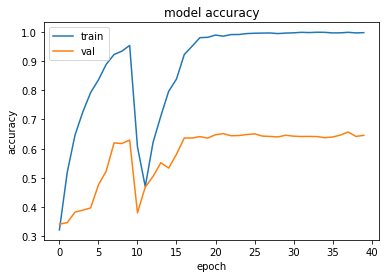

In [27]:
# plot out model accuracy
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

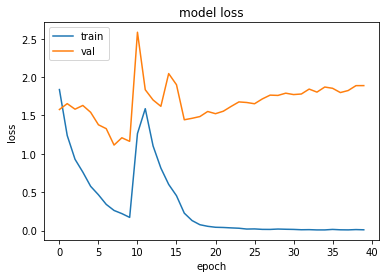

In [22]:
# plot out model loss 
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()